In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt

import cv2
from tqdm import tqdm
import io
import seaborn as sns

from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard,ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import plot_model

import ipywidgets as widgets
from PIL import Image
from IPython.display import display, clear_output

In [4]:
labels = ['CONTROL', 'AD', 'PD']

In [5]:
X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=150

for i in labels:
    folderPath = os.path.join(r'C:\\Users\\mahmoud\\Downloads\\archive\\3_cls', 'train', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
        
for i in labels:
    folderPath = os.path.join(r'C:\\Users\\mahmoud\\Downloads\\archive\\3_cls', 'test', i) 
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        

X_train = np.array(X_train)
Y_train = np.array(Y_train)

100%|█████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 327.99it/s]


In [6]:
X_train.shape 

(7839, 150, 150, 3)

In [7]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

In [8]:
X_train.shape

(7839, 150, 150, 3)

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [10]:
y_train_new = []
y_test_new = []

for i in Y_train:
    y_train_new.append(labels.index(i))#Converting String Label to integer i.e
                                       # CONTROL ---> 0, AD---> 1, PD ---> 2
Y_train = to_categorical(y_train_new) #Converts a class vector (integers) to binary class matrix

for i in Y_test:
    y_test_new.append(labels.index(i))

Y_test = to_categorical(y_test_new)

In [11]:
Y_train

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [12]:
efficientnet_B0 = EfficientNetB0(include_top=False,
    weights='imagenet',
    input_shape=(image_size, image_size, 3))

In [13]:
model = efficientnet_B0.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(3, activation='softmax')(model)

In [14]:
#Merge input and Output of model
model = tf.keras.models.Model(inputs=efficientnet_B0.input, outputs=model)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

 y)                                                                  'block2a_se_expand[0][0]']   
                                                                                                  
 block2a_project_conv (Conv  (None, 38, 38, 24)           2304      ['block2a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block2a_project_bn (BatchN  (None, 38, 38, 24)           96        ['block2a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block2b_expand_conv (Conv2  (None, 38, 38, 144)          3456      ['block2a_project_bn[0][0]']  
 D)                                                                                               
          

                                                                                                  
 block3a_project_conv (Conv  (None, 19, 19, 40)           5760      ['block3a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block3a_project_bn (BatchN  (None, 19, 19, 40)           160       ['block3a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block3b_expand_conv (Conv2  (None, 19, 19, 240)          9600      ['block3a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block3b_e

 block4a_project_conv (Conv  (None, 10, 10, 80)           19200     ['block4a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block4a_project_bn (BatchN  (None, 10, 10, 80)           320       ['block4a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4b_expand_conv (Conv2  (None, 10, 10, 480)          38400     ['block4a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block4b_expand_bn (BatchNo  (None, 10, 10, 480)          1920      ['block4b_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block4c_drop (Dropout)      (None, 10, 10, 80)           0         ['block4c_project_bn[0][0]']  
                                                                                                  
 block4c_add (Add)           (None, 10, 10, 80)           0         ['block4c_drop[0][0]',        
                                                                     'block4b_add[0][0]']         
                                                                                                  
 block5a_expand_conv (Conv2  (None, 10, 10, 480)          38400     ['block4c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5a_e

 block5b_add (Add)           (None, 10, 10, 112)          0         ['block5b_drop[0][0]',        
                                                                     'block5a_project_bn[0][0]']  
                                                                                                  
 block5c_expand_conv (Conv2  (None, 10, 10, 672)          75264     ['block5b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5c_expand_bn (BatchNo  (None, 10, 10, 672)          2688      ['block5c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block5c_expand_activation   (None, 10, 10, 672)          0         ['block5c_expand_bn[0][0]']   
 (Activati

 ormalization)                                                                                    
                                                                                                  
 block6b_expand_conv (Conv2  (None, 5, 5, 1152)           221184    ['block6a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block6b_expand_bn (BatchNo  (None, 5, 5, 1152)           4608      ['block6b_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6b_expand_activation   (None, 5, 5, 1152)           0         ['block6b_expand_bn[0][0]']   
 (Activation)                                                                                     
          

 block6c_add (Add)           (None, 5, 5, 192)            0         ['block6c_drop[0][0]',        
                                                                     'block6b_add[0][0]']         
                                                                                                  
 block6d_expand_conv (Conv2  (None, 5, 5, 1152)           221184    ['block6c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6d_expand_bn (BatchNo  (None, 5, 5, 1152)           4608      ['block6d_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6d_expand_activation   (None, 5, 5, 1152)           0         ['block6d_expand_bn[0][0]']   
 (Activati

                                                                                                  
 top_bn (BatchNormalization  (None, 5, 5, 1280)           5120      ['top_conv[0][0]']            
 )                                                                                                
                                                                                                  
 top_activation (Activation  (None, 5, 5, 1280)           0         ['top_bn[0][0]']              
 )                                                                                                
                                                                                                  
 global_average_pooling2d (  (None, 1280)                 0         ['top_activation[0][0]']      
 GlobalAveragePooling2D)                                                                          
                                                                                                  
 dropout (

In [18]:
model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc'])

In [19]:
tensorBoard = TensorBoard(log_dir="logs")
checkPoint = ModelCheckpoint("efficient_net_B0.h5",
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.3,
                             patience=2,
                             verbose=1,
                             mode='auto',
                             min_delta=0.001)
es = EarlyStopping(monitor='val_loss',
                   patience=5,
                   verbose=1,
                   mode='auto',
                   restore_best_weights=True) 

In [20]:
history = model.fit(X_train, 
                    Y_train,
                    batch_size=32,
                    validation_split=0.1,
                    epochs=20,
                    verbose=1,
                    callbacks=[tensorBoard, checkPoint, reduce_lr, es])

Epoch 1/20
199/199 [==============================] - ETA: 0s - loss: 0.5686 - acc: 0.7261 
Epoch 1: val_loss improved from inf to 0.46660, saving model to efficient_net_B0.h5


C:\Users\mahmoud\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


199/199 [==============================] - 3329s 16s/step - loss: 0.5686 - acc: 0.7261 - val_loss: 0.4666 - val_acc: 0.7847 - lr: 0.0010
Epoch 2/20
199/199 [==============================] - ETA: 0s - loss: 0.3248 - acc: 0.8570 
Epoch 2: val_loss did not improve from 0.46660
199/199 [==============================] - 2667s 13s/step - loss: 0.3248 - acc: 0.8570 - val_loss: 0.6366 - val_acc: 0.7861 - lr: 0.0010
Epoch 3/20
199/199 [==============================] - ETA: 0s - loss: 0.2108 - acc: 0.9129 
Epoch 3: val_loss improved from 0.46660 to 0.22836, saving model to efficient_net_B0.h5
199/199 [==============================] - 3290s 17s/step - loss: 0.2108 - acc: 0.9129 - val_loss: 0.2284 - val_acc: 0.9164 - lr: 0.0010
Epoch 4/20
199/199 [==============================] - ETA: 0s - loss: 0.1542 - acc: 0.9397 
Epoch 4: val_loss did not improve from 0.22836
199/199 [==============================] - 2693s 14s/step - loss: 0.1542 - acc: 0.9397 - val_loss: 0.5135 - val_acc: 0.8796 - lr: 0

In [21]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
actual_label = np.argmax(Y_test, axis=1)
print(classification_report(actual_label, pred))

25/25 [==============================] - 98s 3s/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       360
           1       0.99      1.00      1.00       317
           2       0.93      0.93      0.93       107

    accuracy                           0.98       784
   macro avg       0.97      0.97      0.97       784
weighted avg       0.98      0.98      0.98       784



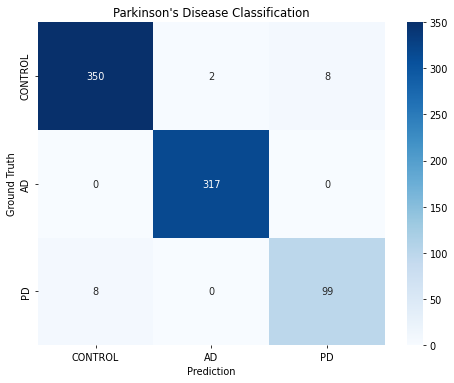

In [22]:
cnf = confusion_matrix(actual_label, pred)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues',annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Parkinson\'s Disease Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

In [23]:
saved_model = tf.keras.models.load_model("./efficient_net_B0.h5")

#Show Model Architecture
plot_model(saved_model,
          to_file='efficient_net_B0.png',
          show_shapes=True,
          show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [31]:
def imagePrediction(upload):
    for name, fileinfo  in uploader.value.items():
        image = Image.open(io.BytesIO(fileinfo['content']))
        
    images = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    images = cv2.resize(images,(150, 150))
    images = images.reshape(1, 150, 150, 3)
    prd = model.predict(images)
    prd = np.argmax(prd, axis = 1)[0]
    
    if prd == 0:
        prd = "CONTROL"
    elif prd == 1:
        prd = "AD"
    elif prd ==2:
        prd = "PD"
        
    print(f'Model Predict That is  a {prd}')

In [32]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [33]:
button = widgets.Button(description= "Predict")
out = widgets.Output()

def on_button_click(_):
    with out:
        clear_output()
        try:
            imagePrediction(uploader)
        except:
            print("Please Enter the Correct Image files")
            
            
button.on_click(on_button_click)
widgets.VBox([button, out])